In [1]:
# !pip install --upgrade fastai torch torchvision torchaudio #--index-url https://download.pytorch.org/whl/cu116

In [2]:
import torch
from torch import nn
print(torch.cuda.is_available())

False


In [3]:
from fastai.collab import CollabDataLoaders, collab_learner
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.random.manual_seed(random_seed)
torch.manual_seed(random_seed) # cpu  vars
torch.cuda.manual_seed_all(random_seed) # gpu 
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True  #needed
torch.backends.cudnn.benchmark = False

import warnings

In [ ]:
%%bigquery df_blackfriday_data
select * from `blackfridayintelia.blackfriday.blackfriday`

In [4]:
# %store -r df_blackfriday_data

## Data Processing

In [5]:
trainset, testset = train_test_split(df_blackfriday_data, random_state=random_seed, test_size=0.25)


In [6]:
ratings_dict = {'item': list(trainset.Product_ID),
                'user': list(trainset.User_ID),
                'rating': list((trainset.Purchase.pow(1/2)- 3.464)/15)}
ratings = pd.DataFrame(ratings_dict)

ratings_test_dict = {'item': list(testset.Product_ID),
                'user': list(testset.User_ID),
                'rating': list((testset.Purchase.pow(1/2) -3.464)/15)}
ratings_test = pd.DataFrame(ratings_test_dict)

In [7]:
ratings.describe()

,user,rating
count,4.125510e+05,412551.000000
mean,1.003031e+06,5.923576
std,1.726562e+03,1.814700
min,1.000001e+06,0.000007
25%,1.001524e+06,4.855432
50%,1.003080e+06,5.749405
75%,1.004479e+06,7.088751
max,1.006040e+06,10.088627


In [8]:
dls = CollabDataLoaders.from_df(ratings, bs=512, seed=random_seed)

## DL

SuggestedLRs(valley=0.001737800776027143)

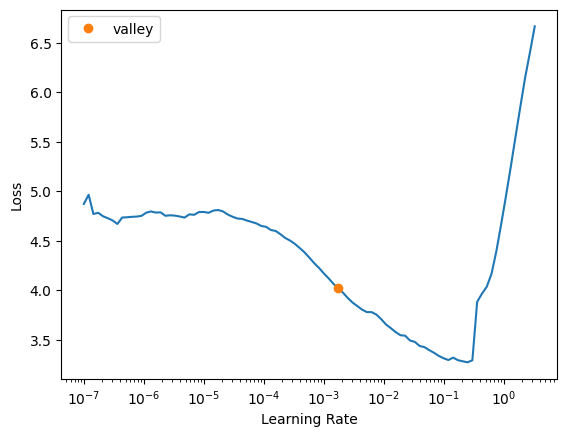

In [9]:
# learn = collab_learner(dls, emb_szs={'user': 5, 'item': 5}, n_factors=10, use_nn=True, y_range=(0, 10))
learn = collab_learner(dls, n_factors=160, use_nn=True, y_range=(0, 10))

learn.lr_find(stop_div=False)

In [10]:
# learn = collab_learner(dls, n_factors=160, use_nn=True, y_range=(0, 10))
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(7, lr_max=5e-3, wd=0.7)

# 0.7517
# 5, 5e-3, 0.2
# 0.737
# 5, 5e-3, 0.3
# 0.734
# 6, 5e-3, 0.5
# 0.733564
# 7, 5e-3, 0.7
# 0.731576

epoch,train_loss,valid_loss,time
0,0.934718,0.911863,00:16
1,0.908088,0.880167,00:16
2,0.894195,0.853422,00:16
3,0.844949,0.821875,00:16
4,0.788623,0.788704,00:16
5,0.720152,0.736413,00:17
6,0.638404,0.735106,00:19


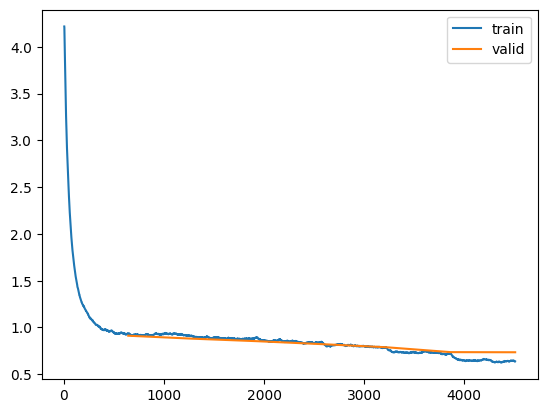

In [11]:
learn.recorder.plot_loss()

In [12]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(3579, 156)
    (1): Embedding(5892, 207)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=363, out_features=160, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=160, out_features=1, bias=True)
    )
    (2): fastai.layers.SigmoidRange(low=0, high=10)
  )
)

In [13]:
from fastai import tabular
tabular.model.get_emb_sz(dls.train_ds, {})

[(3579, 156), (5892, 207)]

In [14]:
dl = learn.dls.test_dl(ratings_test, with_labels=True)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    aaa = learn.get_preds(dl=dl)
    aaa

testset['y'] = (testset['Purchase'].pow(1/2) -3.464)/15
testset['y_pred'] = [x.tolist()[0] for x in aaa[0]]

# testset['y_pred'] = testset['y_pred']*testset['y_pred']*225

from sklearn.metrics import mean_squared_error
from math import sqrt

print('Scaled RMSE', sqrt(mean_squared_error(testset['y'], testset['y_pred'])))
#0.8624

Scaled RMSE 0.8664418089640893


In [15]:
testset['Purchase_pred'] = (testset.y_pred*15 +3.464) * (testset.y_pred*15 +3.464)
print('RMSE on the original test set', sqrt(mean_squared_error(testset['Purchase'], testset['Purchase_pred'])))


RMSE on the original test set 2477.0892526864186


<Axes: title={'center': 'Recommendation - DL Model'}, xlabel='Purchase', ylabel='Purchase_pred'>

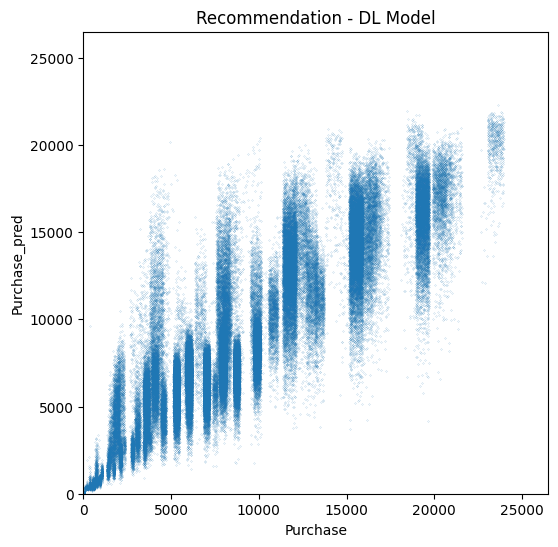

In [16]:
testset[['Purchase', 'Purchase_pred']].plot.scatter(x='Purchase', 
                                                    y='Purchase_pred', 
                                                    xlim=[0,26500], 
                                                    ylim=[0,26500], 
                                                    s=0.01, 
                                                    title='Recommendation - DL Model',
                                                    figsize=(6, 6))